In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Dependence of $t_Q$ on host halo mass

We have measured and assembled from the literature several values of $t_Q$ measured at various redshifts $z$, separately for galaxy groups and galaxy clusters.

From Foltz et al. (2018) it seems reasonable to take as given that $t_Q(z)$ evolves like the dynamical time, $t_\mathrm{dyn} = t_0 (z+1)^{-1.5}$. $t_0$ is the multiplicative factor that normalizes the value for $t_Q$ at $z=0$. From Figure 5, it seems apparent that groups quench galaxies over a longer timescale, i.e., require a higher $t_0$.

If this is true, then it means that the quenching time $t_Q$ depends on the host halo mass.

We would like two answer two questions:

1. What are the most likely values for $t_0$ for the separate galaxy group and cluster data points?
2. What is the significance of the apparent difference in $t_0$ between the group and cluster samples?


## Inspect the data

data points assembled in Foltz et al. (2018)

In [24]:
# clusters (redshift, tQ, uncertainty)
cz = [0.05, 1.05, 0.05, 0.225, 0.05, 1.05, 1.06, 1.55]
ct = [4.25, 1.0, 4, 3.7, 5, 1.5, 1.5, 1.24]
ce = [0.4, 0.25, 2, 0.5, 0.5, 0.5, 0.2, 0.2]

# groups (redshift, tQ, uncertainty)
gz = [0.05, 0.9, 0.4, 0.65, 1, 1.5]
gt = [7, 2.8, 4, 2.58, 2.46, 2.17]
ge = [0.75, 0.5, 0.6, 0.577, 0.577, 0.577]

nominal $t_\mathrm{dyn}$ models

In [25]:
def tdyn(z, t0):
    return t0 * (1 + z)**(-1.5) 

x = np.linspace(0, 2)
ctm = 5.0 * (1 + x)**(-1.5) 
gtm = 7.0 * (1 + x)**(-1.5) 

Reproduce Figure 5:

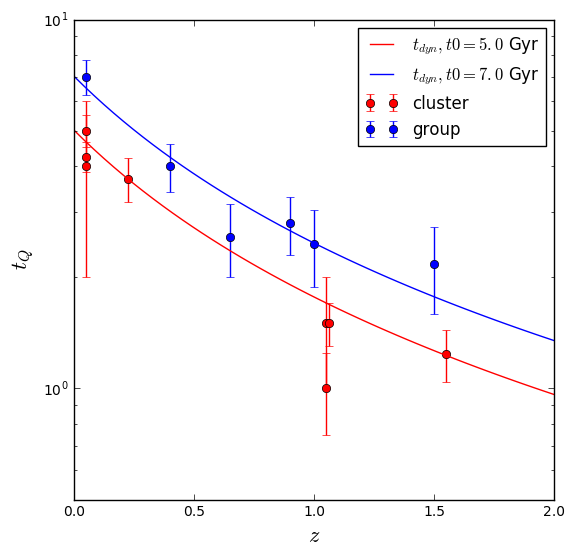

In [26]:
fig = plt.figure(1, figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_yscale("log", nonposy='clip')

ax.errorbar(cz, ct, fmt='ro', yerr=ce, label='cluster')
ax.errorbar(gz, gt, fmt='bo', yerr=ge, label='group')
ax.plot(x, ctm, label='$t_{dyn}, t0=5.0$ Gyr', color='r')
ax.plot(x, gtm, label='$t_{dyn}, t0=7.0$ Gyr', color='b')
ax.set_ylim((0.5, 10))
ax.set_xlim((0, 2))
ax.set_xlabel('$z$', fontsize=16)
ax.set_ylabel('$t_Q$', fontsize=16)
ax.legend()
plt.show(fig)

There is an apparent dependence on host halo mass.

---

## Find the best-fit $t_0$ values and their confidence intervals

Define the likelihood function $p(t | z, \sigma, t_0)$ to be the probability to measure quenching time t at redshift z with uncertainty $\sigma$, given by a normal distribution located at the expected value $t_{dyn}(z, t_0)$ with standard deviation $\sigma$.

In [27]:
def p(x, y, e, t0):
    "calculate probability of point (x, y±e) given t0"
    expected = tdyn(x, t0)
    p = np.exp(-((y-expected)**2)/(2*e**2))/np.sqrt(6.28*e**2)
    return p
p = np.vectorize(p)

verify that p is behaving as expected:

given $t_0$=0.5, at z=1, what is the likelihood of measuring y for $\sigma$=0.25 and 0.35

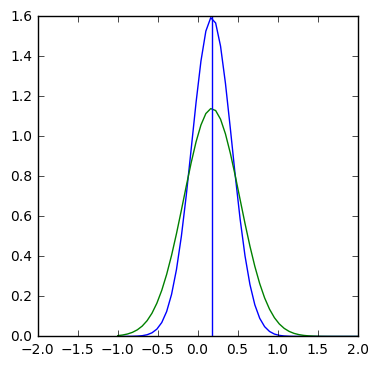

In [28]:
y = np.linspace(-1, 2)
fig = plt.figure(1, figsize=(4, 4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(y, p(1, y, 0.25, 0.5))
ax.plot(y, p(1, y, 0.35, 0.5))
ax.axvline(tdyn(1, 0.5))
ax.set_xlim((-2, 2))
plt.show(fig)

as expected, the most likely value is the expected value $t_{dyn}(z=1, t_0=0.5)$, and a larger error bar leads to a more spread-out PDF with lower peak value.

verify that the output PDF is normalized:

In [29]:
y = np.linspace(-1, 1)
sum(p(1, y, 0.25, 0.5))*(y[2]-y[1])

0.99988795202995173

the posterior function over $t_0$ is:

$$\begin{equation*}
p(t_0 | z_i, t_i, \sigma_i) = \prod_{i=1}^{N} \frac{p(t_i | z_i, \sigma_i, t_0) \times p(t0)}{p(t_i, z_i)}
\end{equation*}$$

with a flat prior on $t_0$, and taking the logarithm of both sides:

$$\begin{equation*}
\mathrm{ln}(p(t_0 | z_i, t_i, \sigma_i)) \propto \sum_{i=1}^{N} \mathrm{ln}(p(t_i | z_i, \sigma_i, t_0))
\end{equation*}$$

we can then recover exact probabilities later by using the normalization relation:

$$\begin{equation*}
\int_{-\infty}^\infty p(t_0 | z_i, t_i, \sigma_i) \mathrm{d}t_0 = 1
\end{equation*}$$

In [30]:
def posterior(t0, zi, ti, ei):
    result = 0
    for z, t, e in zip(zi, ti, ei):
        result += np.log(p(z, t, e, t0))
    result = np.exp(result)
    return result / sum(result)

calculate the posterior PDF for $t_0$ when separately conditioned on the group and cluster data sets

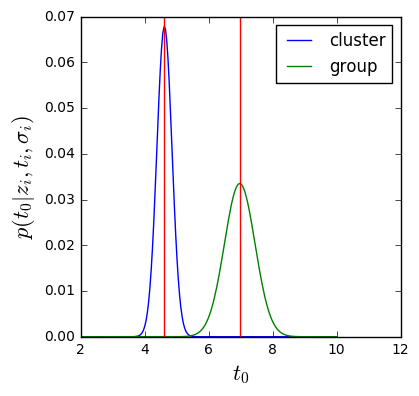

In [31]:
t = np.linspace(2, 10, num=200)
ptc = posterior(t, cz, ct, ce)
ptg = posterior(t, gz, gt, ge)

fig = plt.figure(1, figsize=(4, 4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(t, ptc, label='cluster')
ax.plot(t, ptg, label='group')
ax.axvline(t[ptc == max(ptc)], color='r')
ax.axvline(t[ptg == max(ptg)], color='r')
ax.set_xlim((2, 12))
ax.legend()
ax.set_xlabel('$t_0$', fontsize=16)
ax.set_ylabel('$p(t_0 | z_i, t_i, \sigma_i)$', fontsize=16)
plt.show(fig)

What is the most likely value and 68% confidence interval for $t_0$?

In [32]:
def interval(prob, t):
    tt = [i for _, i in sorted(zip(prob, t))]
    e = np.abs(tt[-1] - tt[int(len(tt)*0.68)])
    return 't0 = {:.2} +/- {:.2} Gyr'.format(tt[-1], e)

In [33]:
# clusters
interval(ptc, t)

't0 = 4.6 +/- 1.3 Gyr'

In [34]:
# groups
interval(ptg, t)

't0 = 7.0 +/- 1.3 Gyr'

---

## Significance of halo mass dependence

We have two data points:

(4.6 +/- 1.3)

(7.0 +/- 1.3)

To establish the significace of their difference, we investigate the distribution of their difference and find the maximum confidence interval that excludes 0.

The difference of two normal distributions is another normal distribution centered at the difference of the means with the standard deviations added in quadrature.

In [35]:
tt = [i for _, i in sorted(zip(ptc, t))]
e1 = np.abs(tt[-1] - tt[int(len(tt)*0.68)])
t1 = tt[-1]

tt = [i for _, i in sorted(zip(ptg, t))]
e2 = np.abs(tt[-1] - tt[int(len(tt)*0.68)])
t2 = tt[-1]
def diff(x):
    return norm.pdf(x, loc=t2-t1, scale=np.sqrt((e1**2)+(e2**2)))

Check that our distribution makes sense

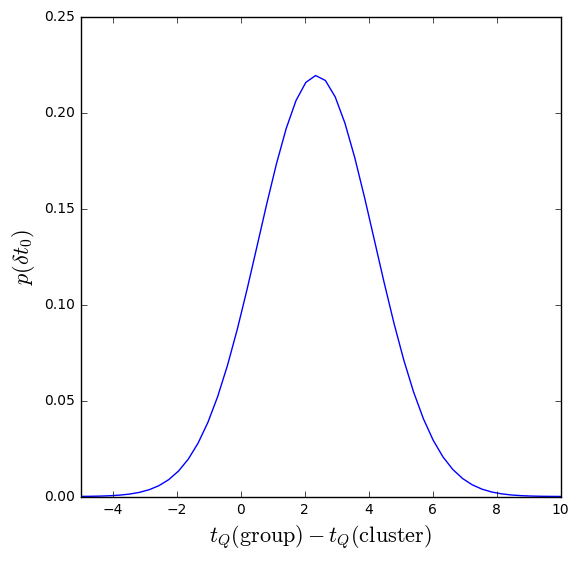

In [36]:
x = np.linspace(-5, 10)
fig = plt.figure(1, figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x, diff(x))
ax.set_xlim((-5, 10))
ax.set_xlabel('$t_Q(\mathrm{group}) - t_Q(\mathrm{cluster})$', fontsize=16)
ax.set_ylabel('$p(\delta t_0)$', fontsize=16)
plt.show(fig)

Find the highest confidence interval

In [37]:
d = diff(x)
sum(d[d > diff(0)])/sum(d)

0.79356093034742115

The highest confidence interval which excludes 0 is ~80%.